In [88]:
# ========================== SETUP & PATHS ==========================
# Importing all the required Libraries
from Bio import SeqIO           # Biopython: used to read and handle FASTA genome sequences
import pandas as pd             # Pandas: data wrangling and analysis
import numpy as np              # NumPy: fast numerical operations
import matplotlib.pyplot as plt # Matplotlib: plotting graphs
import seaborn as sns           # Seaborn: prettier plots built on top of Matplotlib
import re                       # Regular expressions: for text/pattern matching
import statsmodels.api as sm    # Statsmodels: for statistical models
# Machine learning + preprocessing tools from scikit-learn
from sklearn.decomposition import PCA                # PCA: reduce genome mutations to 2D for visualization
from sklearn.model_selection import train_test_split # Splitting data into train/test sets
from sklearn.preprocessing import StandardScaler     # Standardizing numerical features
from sklearn.linear_model import LogisticRegression  # Logistic regression model
from sklearn.pipeline import make_pipeline           # Combine steps (scaling + model) into a single pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix # Metrics to evaluate how well the model predicts severe outcomes

# --- File locations ---
# Central dictionary holding the paths to all input data files and where we will save outputs.
# Change these paths if the data is stored somewhere else on your system.
PATHS = {
    "ref_fasta": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/sequence.fasta",                        # Reference genome
    "seqs_fasta": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/India_fasta.fasta",                    # Sample sequences
    "metadata_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/India_metadata.csv",                 # Sequence metadata
    "merged_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/metadata_with_synthetic_clinical.csv", # Clinical + genomic merged dataset
    "risk_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/risk_matrix_lineage_vax.csv",            # Output: risk matrix by lineage × vaccination
    "coef_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/logit_feature_importance.csv",           # Output: feature importance from logistic regression
    "lin_prop_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/lineage_monthly_proportions.csv",    # Output: lineage proportions by month
    "lin_count_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/lineage_monthly_counts.csv",        # Output: lineage counts by month
    "monthly_sev_all_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/monthly_severity_overall.csv",# Output: severity trends overall
    "monthly_sev_cat_csv": r"C:/Users/Miheer/OneDrive/Documents/Working/Project_data/monthly_severity_by_variant_category.csv", # Output: severity trends by variant category
}

In [90]:
# ========================== SMALL HELPERS ==========================
# These are small utility functions that help standardize our dataset.
# They make sure that important columns like "lineage" and "dates" are properly detected and cleaned.
def detect_lineage_col(df: pd.DataFrame) -> str | None:
    """
    Automatically find the column in the dataframe that looks like a Pango lineage column.
    - Lineages are stored under columns like 'pango_lineage', 'pangolin', or 'lineage'.
    - We ignore columns that are obviously counts, frequencies, or probabilities.
    Returns the name of the best-matching column, or None if no match is found.
    """
    cands = []
    for col in df.columns:
        cl = col.lower()
        # Check if column name contains "pango", "pangolin", or "lineage"
        if any(k in cl for k in ["pango", "pangolin", "lineage"]) and not re.search(r"count|num|freq|prob", cl):
            cands.append(col)
    if not cands:
        return None
    # Prefer names that explicitly mention pango/pangolin, then shorter names
    return sorted(cands, key=lambda c: (0 if re.search(r"pango|pangolin", c.lower()) else 1, len(c)))[0]

def ensure_lineage_column(df: pd.DataFrame, new_col="Lineage") -> pd.DataFrame:
    """
    Make sure the dataframe has a standardized column called 'Lineage'.
    - If a lineage column exists, copy it into a new column named 'Lineage'.
    - If no lineage column is found, fill with 'Unknown'.
    This ensures consistency across different datasets where column names may vary.
    """
    # Try to find a lineage column
    col = detect_lineage_col(df)  
    df = df.copy()
    if col is None:
        # No lineage column found → assign "Unknown"
        df[new_col] = "Unknown"
        print("  No lineage-like column found; using 'Unknown'.")
    else:
        # Clean up the lineage column: convert to string, remove spaces, replace blanks with "Unknown"
        df[new_col] = (
            df[col].astype("string")
                  .fillna("Unknown")
                  .str.strip()
                  .replace({"": "Unknown"})
        )
        print(f" Using lineage column: '{col}' → '{new_col}'")
    return df

def find_col(df: pd.DataFrame, options: list[str]) -> str | None:
    """
    Look for a column in the dataframe that matches any name in the 'options' list.
    - Comparison is case-insensitive (so 'Host_Age' and 'host_age' both match).
    - Returns the first matching column name, or None if no match is found.
    Example: find_col(df, ["host_age","age"]) → returns the actual matching column name.
    """
    # Direct match
    for c in options:
        if c in df.columns:
            return c
     # Case-insensitive match        
    lowmap = {c.lower(): c for c in df.columns}
    for c in options:
        if c.lower() in lowmap:
            return lowmap[c.lower()]
    return None

def ensure_date(df: pd.DataFrame, col="collection_date") -> pd.DataFrame:
    """
    Make sure the dataframe has a valid date column.
    - Tries to parse the given column (default: 'collection_date') as a datetime.
    - Drops any rows with invalid or missing dates.
    Returns the cleaned dataframe with properly formatted dates.
    """
    df = df.copy()
    if col not in df.columns:
        raise ValueError(f"Expected a '{col}' column with sample dates.")
      # Convert the column to datetime format; invalid values become NaT (missing)   
    df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    before = len(df)
     # Drop rows where date is missing or invalid
    df = df.dropna(subset=[col])
    if len(df) < before:
        print(f" Dropped {before - len(df)} rows with invalid/empty '{col}'.")
    return df


In [92]:
# ========================== PART A: GENOMICS PCA ==========================
# Goal of this section:
# 1. Load reference genome and viral sequences (FASTA files).
# 2. Align sequences with metadata (patient/sample information).
# 3. Build a "mutation matrix" showing where sequences differ from the reference.
# 4. Apply PCA (Principal Component Analysis) to reduce high-dimensional mutation data into 2D.
# 5. Plot the sequences in PCA space, colored by lineage, to visualize clustering of variants.
def load_reference_and_sequences(paths=PATHS):
    """
    Load the reference genome and sample sequences, then align them with metadata.
    Steps:
    - Load the reference sequence from a FASTA file.
    - Load multiple SARS-CoV-2 sequences (India in this case).
    - Load metadata (sample IDs, lineage, patient info).
    - Match sequences with metadata using accession numbers.
    - Filter sequences so only those with the same length as the reference remain.
    Returns:
    - ref_seq (string): reference genome sequence.
    - filtered_seqs (list): sequences aligned and cleaned.
    - meta_df (DataFrame): metadata aligned with the filtered sequences.
    """
    # Load reference genome
    ref_record = SeqIO.read(paths["ref_fasta"], "fasta")                  # Read a single record
    ref_seq = str(ref_record.seq).upper()                                 # Convert to uppercase string
    print(f"Reference genome loaded: {ref_record.id}, length: {len(ref_seq)}")

    # Load sequences and metadata
    sequences = list(SeqIO.parse(paths["seqs_fasta"], "fasta"))           # many records
    metadata = pd.read_csv(paths["metadata_csv"])                         # per-sequence info
    print(f"Loaded {len(sequences)} sequences and {len(metadata)} metadata records.")

    # Shorten FASTA ids (strip trailing .version) to match metadata Accession
    fasta_ids = [rec.id.split(".")[0] for rec in sequences]               
    metadata["ShortAccession"] = metadata["Accession"].astype(str).str.split(".").str[0]

    # Keep rows present in both FASTA and metadata
    metadata_matched = metadata[metadata["ShortAccession"].isin(fasta_ids)].reset_index(drop=True)
    sequences_matched = [rec for rec in sequences if rec.id.split(".")[0] in metadata_matched["ShortAccession"].values]
    print(f"Matched {len(sequences_matched)} sequences to metadata.")

    # Keep only sequences with exact length as reference
    filtered_seqs, filtered_meta = [], []
    for rec, meta_row in zip(sequences_matched, metadata_matched.itertuples(index=False)):
        if len(rec.seq) == len(ref_seq):
            filtered_seqs.append(rec)
            filtered_meta.append(meta_row)
    print(f"Sequences with exact length match: {len(filtered_seqs)}")

    # Convert filtered_meta back to DataFrame
    meta_df = pd.DataFrame(filtered_meta)
    return ref_seq, filtered_seqs, meta_df

def compute_mutation_vector(seq: str, ref: str) -> list[int]:
    """
    Compare one sequence to the reference, base by base.
    - If base matches → 0
    - If base differs (A/C/G/T mismatch) → 1
    - If missing/ambiguous (e.g., N) → -1
    Returns:
    - A list of integers representing mutation presence/absence per position.
    """
    s = str(seq).upper()
    out = []
    for a, b in zip(s, ref):
        if a == b:
            out.append(0)  # match
        elif a in "ACGT" and b in "ACGT":
            out.append(1)  # mismatch
        else:
            out.append(-1) # missing/ambiguous
    return out

def pca_on_mutations(ref_seq: str, filtered_seqs: list[SeqIO.SeqRecord], meta_df: pd.DataFrame):
    """
    Run PCA on mutation profiles to visualize clusters of sequences by lineage.
    Steps:
    - Build a mutation matrix (rows = sequences, columns = genome positions).
    - Remove sequences with >10% missing data.
    - Replace missing (-1) with 0 (treat as "neutral"/match).
    - Apply PCA to reduce dimensionality to 2D.
    - Plot sequences in PCA space, colored by lineage.
    """
    # Build mutation matrix (rows: sequences, cols: positions)
    mutation_matrix = np.array([compute_mutation_vector(rec.seq, ref_seq) for rec in filtered_seqs])
    print("Mutation matrix shape (pre-filter):", mutation_matrix.shape)

    # Filter out rows with >10% missing
    valid_rows = (mutation_matrix != -1).mean(axis=1) > 0.90
    mutation_matrix = mutation_matrix[valid_rows]
    metadata_final = meta_df.iloc[np.where(valid_rows)[0]].reset_index(drop=True)
    print("Final filtered mutation matrix shape:", mutation_matrix.shape)

    # Replace -1 with 0 (treat missing as match-neutral)
    mutation_matrix = np.where(mutation_matrix == -1, 0, mutation_matrix)

    # PCA to 2D
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(mutation_matrix)

        # Add lineage labels for coloring
    meta_lineaged = ensure_lineage_column(metadata_final, new_col="Lineage")
    hue_vals = meta_lineaged["Lineage"] if "Lineage" in meta_lineaged.columns else "Unknown"

    # Plot PCA scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=pca_result[:, 0], y=pca_result[:, 1],
        hue=hue_vals, palette="tab10", alpha=0.7, s=60, edgecolor='w'
    )
    plt.title("PCA of SARS-CoV-2 Sequences by Lineage")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(title="Lineage", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



In [71]:
# ========================== PART B: CLINICAL + RISK MATRIX ==========================
# Goal of this section:
# 1) Load the merged clinical + metadata CSV (dates, lineage, vaccination, severity, etc.).
# 2) Create a binary target "SevereOrWorse" = 1 if Severe/Critical OR Death, else 0.
# 3) Compute a risk matrix: % SevereOrWorse for each (Lineage × Vaccination) combination.
# 4) Save the tidy risk table to CSV and visualize it as a heatmap.
def build_risk_matrix(paths=PATHS, top_n=12):
    """
    Load clinical/metadata, construct 'SevereOrWorse', and produce a heatmap of
    % severe outcomes by Lineage × Vaccination status.

    Args:
        paths (dict): file path dictionary (uses paths["merged_csv"], paths["risk_csv"])
        top_n (int): keep only the top N lineages by total sample count to avoid clutter

    Returns:
        merged (pd.DataFrame): cleaned dataframe with a standardized 'Lineage' and 'SevereOrWorse' flag
    """
    # 1) Load the merged dataset (clinical + lineage info), parse dates if present
    merged = pd.read_csv(paths["merged_csv"], parse_dates=["collection_date"], dayfirst=True)
      # Standardize/ensure a 'Lineage' column exists regardless of original column name
    merged = ensure_lineage_column(merged, new_col="Lineage")

    # 2) Build the target: SevereOrWorse = 1 if (severity in {Severe, Critical}) OR (outcome == Death)
      #    We accept several common column name variants (case-insensitive).
    sev_col = find_col(merged, ["disease_severity","severity","Disease_Severity"])
    if sev_col is None:
        raise ValueError("No disease severity column found (e.g., 'disease_severity').")
    outcome_col = find_col(merged, ["outcome"])

    severe_flag = merged[sev_col].astype(str).str.title().isin(["Severe","Critical"])
    if outcome_col is not None:
        severe_flag |= merged[outcome_col].astype(str).str.title().eq("Death")
    merged["SevereOrWorse"] = severe_flag.astype(int)

    # Vaccination column is our main proxy for host immunity here
    vax_col = find_col(merged, ["vaccination_status","Vaccination_status","vaccination","Vaccine_Status"])
    if vax_col is None:
        raise ValueError("No vaccination status column found (e.g., 'vaccination_status').")

    # 3) Compute the risk matrix: mean of SevereOrWorse 
    risk = (merged.groupby(["Lineage", vax_col], dropna=False)["SevereOrWorse"]
                  .agg(rate="mean", n="count")
                  .reset_index())
    risk["rate_pct"] = (risk["rate"] * 100).round(1)

      # Keep only the most represented lineages to make the heatmap readable 
    top_lineages = (risk.groupby("Lineage")["n"].sum().sort_values(ascending=False).head(top_n).index)
    risk_top = risk[risk["Lineage"].isin(top_lineages)].copy()
      # Save a tidy CSV of the risk table for reporting or downstream analysis
    risk_top.sort_values(["Lineage", vax_col]).to_csv(paths["risk_csv"], index=False)
    print("Saved risk matrix →", paths["risk_csv"])

    # 4) Plot the heatmap: rows = lineage, columns = vaccination, cells = % severe
    heat = risk_top.pivot(index="Lineage", columns=vax_col, values="rate_pct")
    plt.figure(figsize=(10, 7))
    sns.heatmap(heat, 
                annot=True, fmt=".1f",  # show the exact % in each cell
                cmap="mako",            # color palette
                cbar_kws={"label": "% Severe/Critical/Death"})
    plt.title("Risk matrix: % Severe/Critical/Death by Lineage × Vaccination")
    plt.xlabel("Vaccination status")
    plt.ylabel("Lineage (top by sample size)")
    plt.tight_layout()
    plt.show()
  # Return the cleaned dataframe so later steps can reuse it
    return merged


In [94]:
# ========================== PART C: PREDICTIVE MODEL ==========================
def logistic_model(merged: pd.DataFrame, paths=PATHS):
    """
    Train and evaluate a logistic regression model that predicts SevereOrWorse.
    Also exports feature importances (coefficients) to CSV.
    """
    # -----------------------------
    # 1) Select feature columns
    # -----------------------------
    # Features: numeric + categorical
    feature_cols = []
    if "host_age" in merged.columns:
        feature_cols.append("host_age") # age is a strong clinical predictor

    # Categorical features (will be one-hot encoded)
    cat_cols = []
    sex_col = find_col(merged, ["host_sex","sex","gender"])
    if sex_col: cat_cols.append(sex_col)
    vax_col = find_col(merged, ["vaccination_status","Vaccination_status","vaccination","Vaccine_Status"])
    if vax_col: cat_cols.append(vax_col)
    comorb_col = find_col(merged, ["comorbidities","Comorbidities","co_morbidities"])
    if comorb_col: cat_cols.append(comorb_col)
    prior_inf_col = find_col(merged, ["prior_infection","Prior_infection","prior_covid","Previous_Infection"])
    if prior_inf_col: cat_cols.append(prior_inf_col)

    # Variant info: prefer provided category; else capped Lineage
    merged = ensure_lineage_column(merged, new_col="Lineage")
    variant_cat_col = find_col(merged, ["variant_category","Variant_category"])
    X = merged.copy()
    if variant_cat_col:
        # Prefer high-level variant categories
        cat_cols.append(variant_cat_col)
    else:
        # Collapse to top 15 lineages
        top_lin = X["Lineage"].value_counts().head(15).index
        X["Lineage_capped"] = np.where(X["Lineage"].isin(top_lin), X["Lineage"], "Other")
        cat_cols.append("Lineage_capped")
    # -----------------------------
    # 2) Build design matrix X and target y
    # -----------------------------
    # Numeric matrix
    X_num = X[feature_cols].copy() if feature_cols else pd.DataFrame(index=X.index)
    # One-hot encode categorical variables
    X_cat = pd.get_dummies(X[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=X.index)
    # Concatenate numeric + categorical to form the final feature matrix
    X_design = pd.concat([X_num, X_cat], axis=1)
    # Target vector: already prepared earlier as 0/1 SevereOrWorse
    y = merged["SevereOrWorse"].astype(int)

    # -----------------------------
    # 3) Train/test split
    # -----------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X_design, y, test_size=0.25, random_state=42, stratify=y
    )
    #'stratify=y' preserves the severe/non-severe proportion in both splits.

    # -----------------------------
    # 4) Pipeline: scale + logistic regression
    # -----------------------------
    # We scale features because some numeric features can be on different scales,
    # and we use with_mean=False since the matrix can be sparse (from one-hot encoding).
    model = make_pipeline(
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=2000) # increase max_iter to ensure convergence
    )
     # Fit the model
    model.fit(X_train, y_train)

    # -----------------------------
    # 5) Evaluate model performance
    # -----------------------------
    proba = model.predict_proba(X_test)[:, 1]   # predicted probability of class 1
    auc = roc_auc_score(y_test, proba)          # threshold-free ranking metric
    pred = (proba >= 0.5).astype(int)           # default 0.5 threshold for class label
    print(f"\nAUC (test): {auc:.3f}")
    print("\nClassification report (threshold=0.5):")
    print(classification_report(y_test, pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))

    # -----------------------------
    # 6) Export feature importances
    # -----------------------------
    # For logistic regression, coefficients indicate log-odds effects.
    # Larger absolute values ⇒ stronger association with the outcome (direction given by sign).
    clf = model.named_steps["logisticregression"]
    coefs = pd.Series(clf.coef_.ravel(), index=X_design.columns).sort_values(key=np.abs, ascending=False)
    coefs.to_csv(paths["coef_csv"], header=["coef"])
    print("\nTop 15 features by |coef|:")
    print(coefs.head(15))
    print("Saved feature importances →", paths["coef_csv"])


In [96]:
# ========================== PART D: TEMPORAL TRENDS ==========================
def lineage_over_time(paths=PATHS, top_n=12):
    """
    Purpose:
      - Summarize how variant lineages change over calendar time.
      - Export monthly counts/proportions and draw stacked-area charts.

    Steps:
      1) Load merged clinical+metadata.
      2) Ensure a clean 'Lineage' column and valid 'collection_date'.
      3) Aggregate by month and (collapsed) lineage.
      4) Save tidy tables and plot proportions and counts.
    """
    # 1) Load and standardize core fields
    merged = pd.read_csv(paths["merged_csv"])
    merged = ensure_lineage_column(merged, new_col="Lineage")   # normalize lineage naming
    merged = ensure_date(merged, col="collection_date")         # parse/clean dates
    # 2) Create a month key
    df = merged.copy()
    df["month"] = df["collection_date"].dt.to_period("M").dt.to_timestamp()

     # 3) Collapse rare lineages to "Other" for readability, plus row-normalized proportions
    top_lineages = df["Lineage"].value_counts().head(top_n).index
    df["Lineage_collapsed"] = np.where(df["Lineage"].isin(top_lineages), df["Lineage"], "Other")

    # 4) Monthly counts per lineage
    counts = (df.groupby(["month", "Lineage_collapsed"]).size().rename("count").reset_index())
    counts_wide = counts.pivot(index="month", columns="Lineage_collapsed", values="count").fillna(0).sort_index()
    props_wide = counts_wide.div(counts_wide.sum(axis=1), axis=0).fillna(0)

    # 5) Save outputs for reporting.
    counts_wide.to_csv(paths["lin_count_csv"])
    props_wide.to_csv(paths["lin_prop_csv"])
    print(f"Saved counts → {paths['lin_count_csv']}")
    print(f"Saved proportions → {paths['lin_prop_csv']}")

    # 6) Plot A: Stacked area of monthly proportions
    plt.figure(figsize=(12, 6))
    x = counts_wide.index                       # monthly timeline
    order = list(props_wide.columns)            # lineage order in legend
    y = [props_wide[c].values for c in order]   # proportions per lineage
    plt.stackplot(x, y, labels=order)
    plt.title("Variant share over time (monthly proportions)")
    plt.xlabel("Month"); plt.ylabel("Share of sequences")
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1), ncol=1, frameon=False)
    plt.tight_layout(); plt.show()
    # 7) Plot B: Stacked area of monthly raw counts
    plt.figure(figsize=(12, 6))
    y_counts = [counts_wide[c].values for c in order]
    plt.stackplot(x, y_counts, labels=order)
    plt.title("Variant counts over time (monthly)")
    plt.xlabel("Month"); plt.ylabel("Number of sequences")
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1), ncol=1, frameon=False)
    plt.tight_layout(); plt.show()

def severity_time_series(paths=PATHS):
    """
    Purpose:
      - Track severity over time overall and by variant category.
      - Provide context by overlaying severity on top of variant share.
      - Optionally show severity trends stratified by vaccination status.

    Inputs/assumptions:
      - 'collection_date' exists and is parseable.
      - 'variant_category' preferred; if missing, approximate from 'Lineage' (Alpha/Delta/Omicron/Other).
      - 'SevereOrWorse' target is derived here from severity/outcome.

    Outputs:
      - CSVs with monthly severity (overall and by variant category).
      - Three plots:
          A) Variant share + severity overlay
          B) (saved tables only; plotting done in A)
          C) Severity over time by vaccination status (if vaccination column exists)
    """
    # 1) Load and standardize
    merged = pd.read_csv(paths["merged_csv"])
    merged = ensure_lineage_column(merged, new_col="Lineage")
    merged = ensure_date(merged, col="collection_date")

    # 2) Ensure a variant category exists; if not, derive a coarse mapping from lineage
    if "variant_category" not in merged.columns:
        def _var_cat(p: str) -> str:
            p = str(p).upper()
            # Simple, conservative mapping for presentation
            if re.match(r"^(BA|BF|BJ|BL|BN|BM|BR|BQ|CH|CA|XBB|XBD|DY)", p): return "Omicron"
            if p.startswith("AY") or p.startswith("B.1.617.2") or p == "DELTA": return "Delta"
            if p.startswith("B.1.1.7") or p == "ALPHA": return "Alpha"
            return "Other"
        merged["variant_category"] = merged["Lineage"].map(_var_cat)

    # 3) Build SevereOrWorse = 1 if Severe/Critical OR outcome==Death
    sev_col = find_col(merged, ["disease_severity","severity","Disease_Severity"])
    if sev_col is None:
        raise ValueError("No severity column found.")
    outcome_col = find_col(merged, ["outcome"])

    severe_flag = merged[sev_col].astype(str).str.title().isin(["Severe","Critical"])
    if outcome_col is not None:
        severe_flag |= merged[outcome_col].astype(str).str.title().eq("Death")
    merged["SevereOrWorse"] = severe_flag.astype(int)

    # Additional outcomes
    has_hosp = "hospitalization" in merged.columns
    if has_hosp:
        merged["Hosp"] = merged["hospitalization"].astype(str).str.title().eq("Yes").astype(int)
    if outcome_col:
        merged["Death"] = merged[outcome_col].astype(str).str.title().eq("Death").astype(int)
    # Month key for time series
    merged["month"] = merged["collection_date"].dt.to_period("M").dt.to_timestamp()

    # 4) Monthly overall rates
    agg_dict = {"SevereOrWorse": "mean"}
    if has_hosp: agg_dict["Hosp"] = "mean"
    if outcome_col: agg_dict["Death"] = "mean"

    overall = (merged.groupby("month").agg(agg_dict)
                     .rename(columns={"SevereOrWorse": "severe_rate",
                                      "Hosp": "hosp_rate" if has_hosp else None,
                                      "Death": "death_rate" if outcome_col else None})
                     .reset_index())
     # attach monthly sample size
    overall["n"] = merged.groupby("month").size().values
    overall.to_csv(paths["monthly_sev_all_csv"], index=False)
    print(f"Saved overall monthly severity → {paths['monthly_sev_all_csv']}")

    # 5) Monthly rates by variant category
    bycat = (merged.groupby(["month","variant_category"]).agg(agg_dict)
                   .rename(columns={"SevereOrWorse": "severe_rate",
                                    "Hosp": "hosp_rate" if has_hosp else None,
                                    "Death": "death_rate" if outcome_col else None})
                   .reset_index())
    bycat["n"] = merged.groupby(["month","variant_category"]).size().values
    bycat.to_csv(paths["monthly_sev_cat_csv"], index=False)
    print(f"Saved monthly severity by variant_category → {paths['monthly_sev_cat_csv']}")

     # 6) Plot A: Stacked area of variant share with severity overlayed as a line
    cat_counts = (merged.groupby(["month","variant_category"]).size().rename("count").reset_index())
    wide_counts = cat_counts.pivot(index="month", columns="variant_category", values="count").fillna(0).sort_index()
    wide_props = wide_counts.div(wide_counts.sum(axis=1), axis=0).fillna(0)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    x = wide_props.index
    cats = list(wide_props.columns)
    y = [wide_props[c].values for c in cats]
    ax1.stackplot(x, y, labels=cats)
    ax1.set_ylabel("Variant share"); ax1.set_xlabel("Month")
    ax1.set_title("Variant share over time with severity overlay")
    # Overlay severity
    ax2 = ax1.twinx()
    ax2.plot(overall["month"], overall["severe_rate"]*100, linewidth=2)
    ax2.set_ylabel("% Severe/Critical/Death")
    ax1.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False, title="Variant category")
    plt.tight_layout(); plt.show()

    # 7) Plot C: Severity over time by vaccination status
    vax_col = find_col(merged, ["vaccination_status","Vaccination_status","vaccination","Vaccine_Status"])
    if vax_col:
         # Normalize a few common capitalization variants for nicer legends
        m2 = merged.copy()
        m2[vax_col] = m2[vax_col].astype(str).str.title()
        m2[vax_col] = m2[vax_col].replace({"Partially Vaccinated":"Partially vaccinated",
                                           "Fully Vaccinated":"Fully vaccinated"})
        known_levels = ["Unvaccinated","Partially vaccinated","Fully vaccinated","Boosted"]
        m2[vax_col] = np.where(m2[vax_col].isin(known_levels), m2[vax_col], "Other/Unknown")
        # Compute monthly mean of SevereOrWorse per vaccination level
        tvr = (m2.groupby(["month", vax_col])["SevereOrWorse"]
                 .mean().reset_index().rename(columns={"SevereOrWorse":"severe_rate"}))
        # Plot lines per vaccination status
        fig, ax = plt.subplots(figsize=(12, 6))
        for lvl in known_levels + ["Other/Unknown"]:
            sub = tvr[tvr[vax_col] == lvl]
            if len(sub):
                ax.plot(sub["month"], sub["severe_rate"]*100, label=lvl)
        ax.set_title("Severity over time by vaccination status")
        ax.set_xlabel("Month"); ax.set_ylabel("% Severe/Critical/Death")
        ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False)
        plt.tight_layout(); plt.show()
    else:
        print(" Vaccination column not found—skipping vaccination-stratified timeline.")



In [98]:
# ========================== PART E: HYBRID IMMUNITY VS SEVERITY ==========================
def plot_hybrid_immunity_vs_severity(paths=PATHS, min_n_per_group=30):
    """
    Minimal version:
      - Uses vaccination_status × prior_infection to define 'ImmunityProfile'
      - Plots % Severe/Critical/Death per profile
    Assumes clean columns: 'disease_severity', 'vaccination_status', 'prior_infection' (Yes/No).
    """
    # Load
    merged = pd.read_csv(paths["merged_csv"])

    # Columns (use your existing helper to be safe; or hardcode names if truly minimal)
    sev_col   = find_col(merged, ["disease_severity","severity","Disease_Severity"]) or "disease_severity"
    vax_col   = find_col(merged, ["vaccination_status","Vaccination_status","vaccination","Vaccine_Status"]) or "vaccination_status"
    prior_col = find_col(merged, ["prior_infection","Prior_infection","prior_covid","Previous_Infection"]) or "prior_infection"

    if sev_col not in merged or vax_col not in merged:
        raise ValueError("Missing required columns: severity and vaccination_status.")

    # Build SevereOrWorse (Severe/Critical == 1); uncomment outcome line if you want to include deaths too
    severe_flag = merged[sev_col].astype(str).str.title().isin(["Severe", "Critical"])
    # outcome_col = find_col(merged, ["outcome"])
    # if outcome_col: severe_flag |= merged[outcome_col].astype(str).str.title().eq("Death")
    merged["SevereOrWorse"] = severe_flag.astype(int)

    # Prior infection: keep Yes/No; anything else → Unknown (very light cleanup)
    if prior_col in merged:
        prior = merged[prior_col].astype(str).str.title()
        merged["PriorInf"] = np.where(prior.isin(["Yes", "No"]), prior, "Unknown")
    else:
        merged["PriorInf"] = "Unknown"

    # Hybrid label
    merged["ImmunityProfile"] = merged[vax_col].astype(str) + " × " + merged["PriorInf"]

    # Aggregate (% severe and n)
    agg = (merged.groupby("ImmunityProfile")["SevereOrWorse"]
                 .agg(rate="mean", n="count")
                 .reset_index())

    # Filter small groups
    agg = agg[agg["n"] >= min_n_per_group].copy()
    if agg.empty:
        print(f"No immunity groups with at least {min_n_per_group} samples.")
        return

    agg["rate_pct"] = (agg["rate"] * 100).round(1)
    agg = agg.sort_values("rate", ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=agg, x="ImmunityProfile", y="rate_pct")
    plt.title("% Severe/Critical/Death by Hybrid Immunity (Vaccination × Prior Infection)")
    plt.xlabel("Immunity Profile")
    plt.ylabel("% Severe/Critical/Death")
    plt.xticks(rotation=30, ha="right")
    for i, row in enumerate(agg.itertuples(index=False)):
        plt.text(i, row.rate_pct + 0.5, f"n={int(row.n)}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


Reference genome loaded: NC_045512.2, length: 29903
Loaded 1864 sequences and 1864 metadata records.
Matched 1864 sequences to metadata.
Sequences with exact length match: 18
Mutation matrix shape (pre-filter): (18, 29903)
Final filtered mutation matrix shape: (18, 29903)
 Using lineage column: 'Pangolin' → 'Lineage'


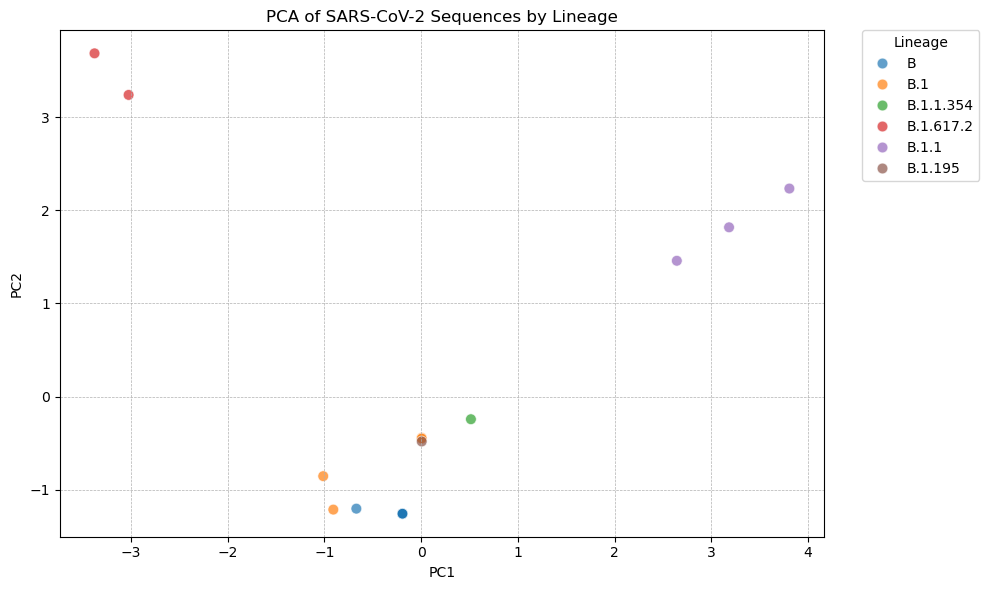

 Using lineage column: 'Pangolin_x' → 'Lineage'
Saved risk matrix → C:/Users/Miheer/OneDrive/Documents/Working/Project_data/risk_matrix_lineage_vax.csv


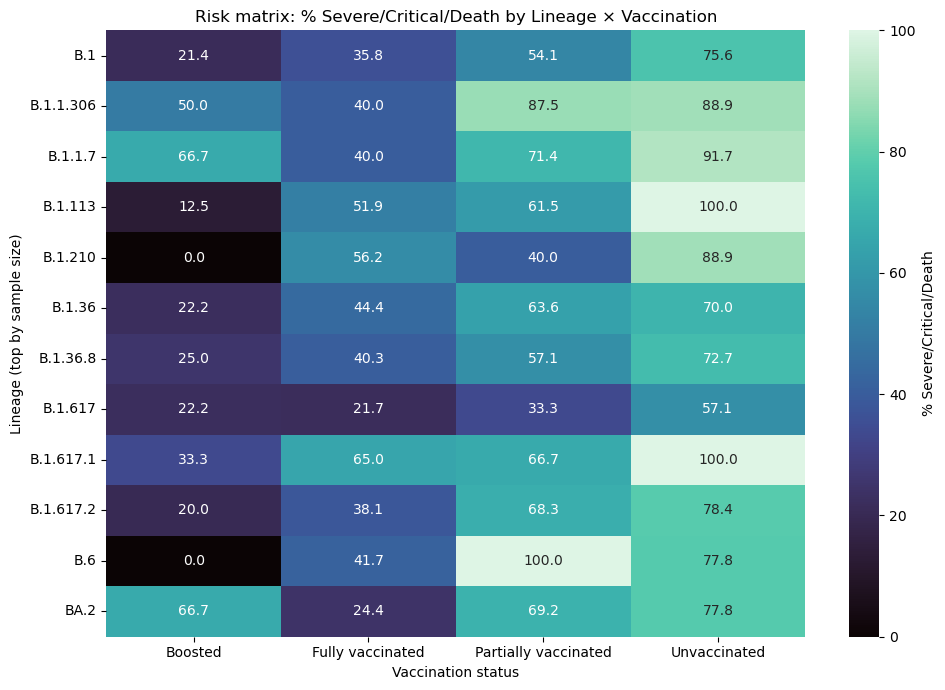

 Using lineage column: 'Pangolin_x' → 'Lineage'

AUC (test): 0.814

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.737     0.749     0.743       243
           1      0.721     0.709     0.715       223

    accuracy                          0.730       466
   macro avg      0.729     0.729     0.729       466
weighted avg      0.729     0.730     0.729       466

Confusion matrix:
 [[182  61]
 [ 65 158]]

Top 15 features by |coef|:
vaccination_status_Unvaccinated            1.053641
host_age                                   0.988726
vaccination_status_Partially vaccinated    0.534101
comorbidities_Multiple                     0.478804
variant_category_Omicron                  -0.356204
variant_category_Delta                     0.315955
comorbidities_Hypertension                 0.236148
vaccination_status_Fully vaccinated        0.165272
variant_category_Other                    -0.153140
host_sex_Male               

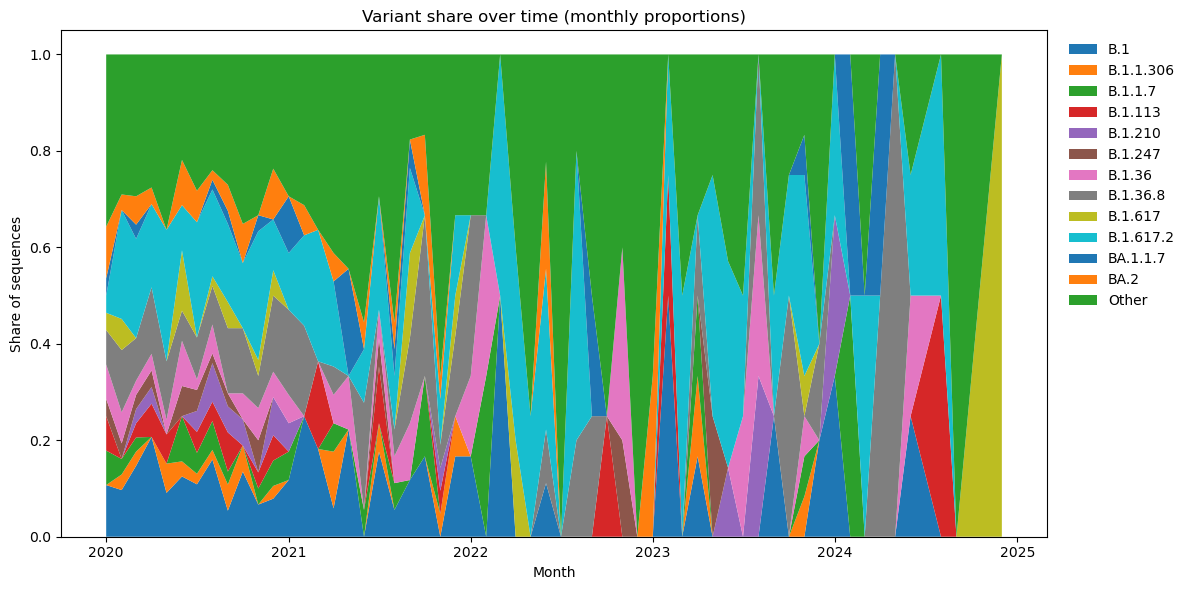

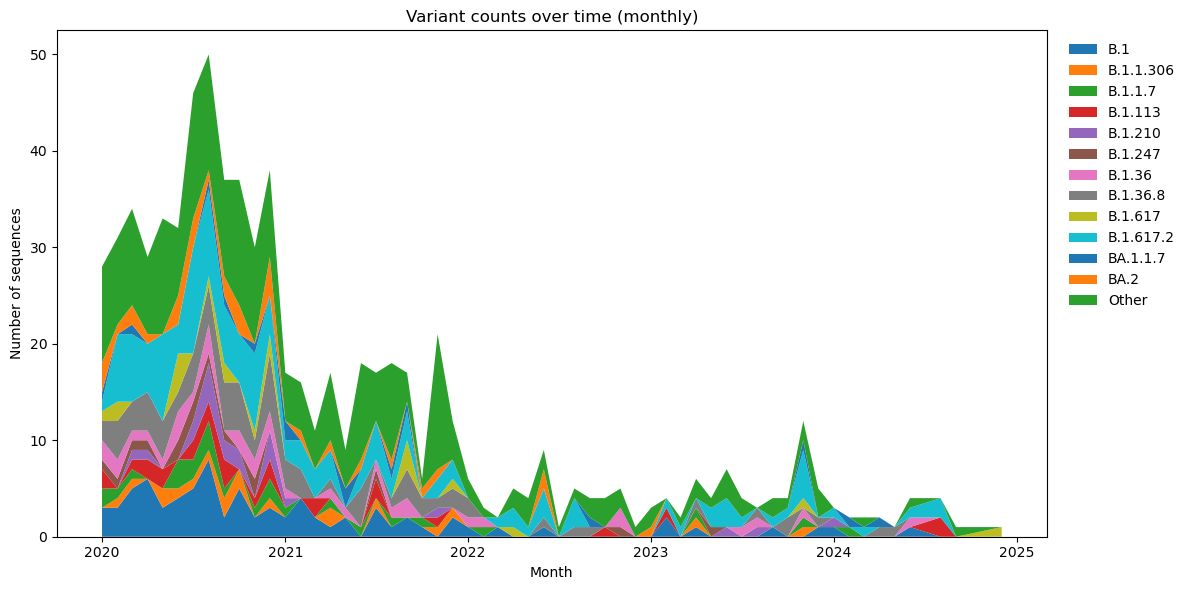

 Using lineage column: 'Pangolin_x' → 'Lineage'
 Dropped 1133 rows with invalid/empty 'collection_date'.
Saved overall monthly severity → C:/Users/Miheer/OneDrive/Documents/Working/Project_data/monthly_severity_overall.csv
Saved monthly severity by variant_category → C:/Users/Miheer/OneDrive/Documents/Working/Project_data/monthly_severity_by_variant_category.csv


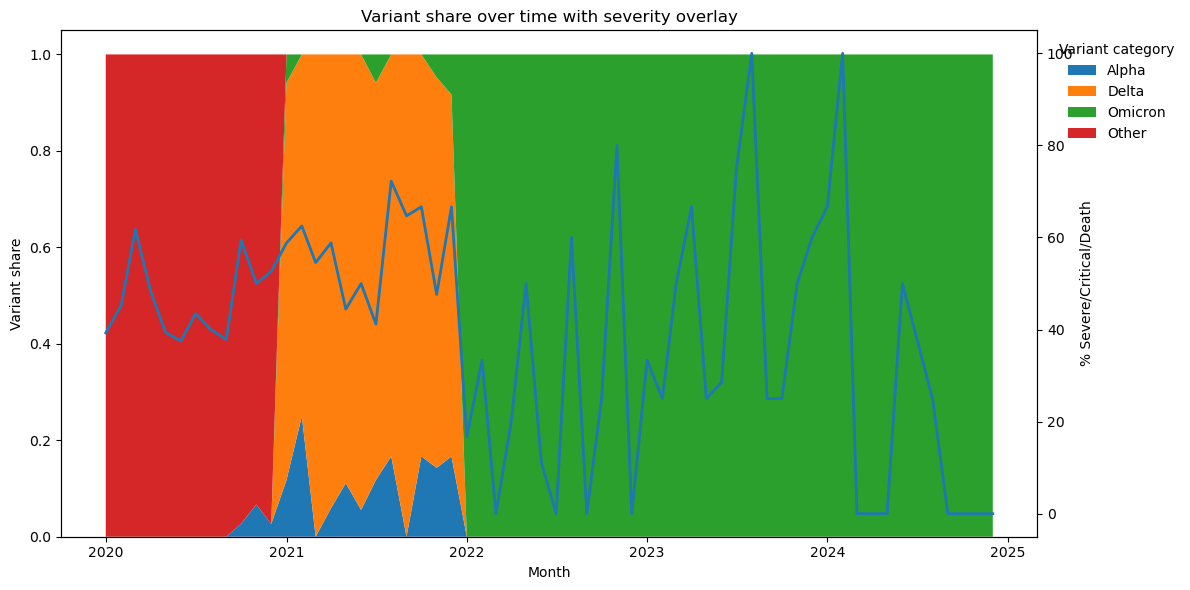

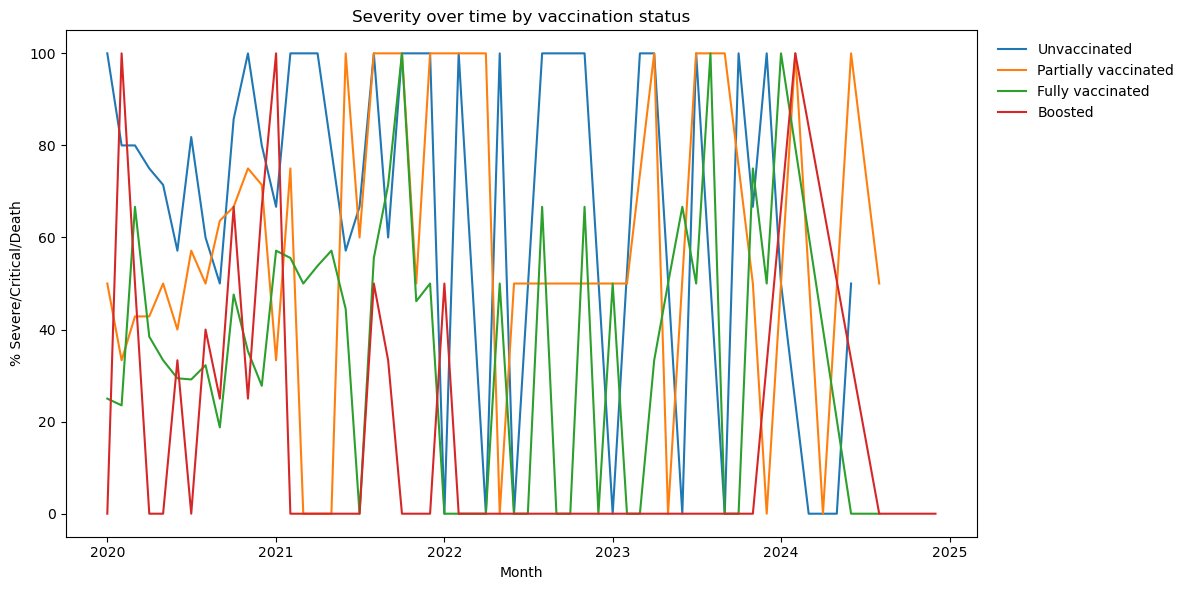

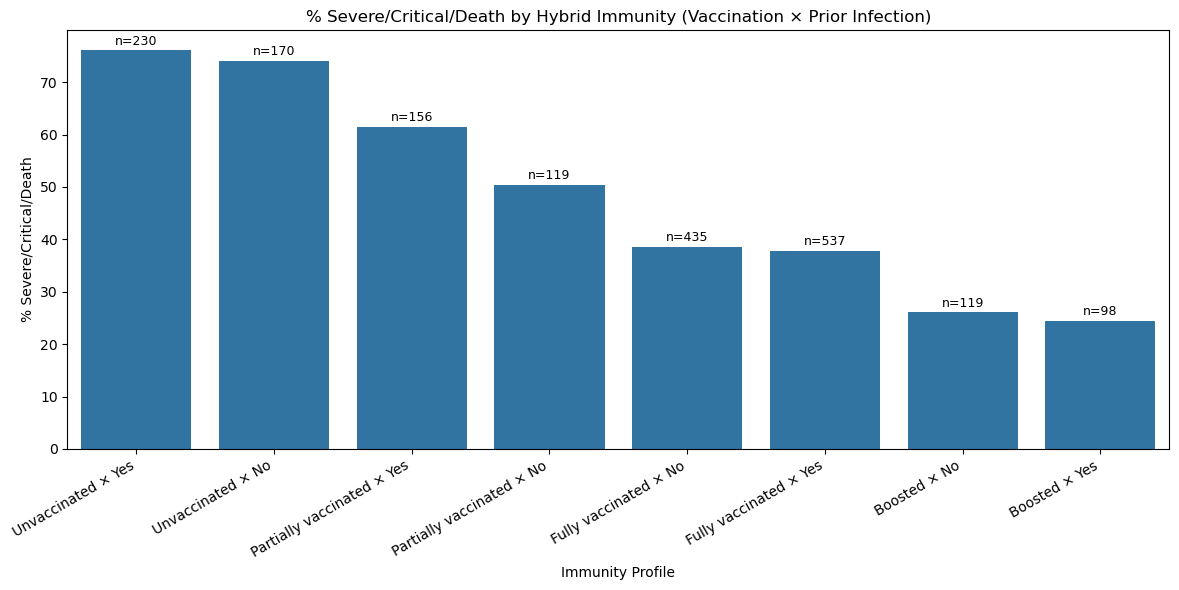

In [100]:
# ========================== MAIN ==========================
if __name__ == "__main__":
    # --- A) GENOMICS PCA ---
    # Load the reference genome + sample FASTA sequences + metadata,
    # then compute and plot PCA of mutation patterns colored by lineage.
    ref_seq, filtered_seqs, meta_df = load_reference_and_sequences(PATHS)
    pca_on_mutations(ref_seq, filtered_seqs, meta_df)

    # --- B) CLINICAL RISK MATRIX ---
    # Merge metadata with clinical data to build a risk matrix:
    # calculates % Severe/Critical/Death for each (Lineage × Vaccination group).
    merged_for_model = build_risk_matrix(PATHS, top_n=12)

    # --- C) PREDICTIVE MODEL ---
    # Train/test a Logistic Regression model to predict SevereOrWorse
    # from host features (age, sex, comorbidities, vaccination, lineage, etc.).
    # Prints model performance (AUC, confusion matrix, report).
    logistic_model(merged_for_model, PATHS)

    # --- D) TEMPORAL TRENDS ---
    # 1. Track variant (lineage) share and counts over time (stacked plots).
    # 2. Track severity trends over time (overall, by variant category, and by vaccination strata).
    lineage_over_time(PATHS, top_n=12)
    severity_time_series(PATHS)

    # --- E) HYBRID IMMUNITY VS SEVERITY ---
    # New analysis: combines Vaccination × Prior Infection to create "ImmunityProfile".
    # Plots % Severe/Critical/Death for each hybrid immunity group.
    plot_hybrid_immunity_vs_severity(PATHS, min_n_per_group=30)
